# Import the libraries

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB
from cvxopt import matrix, solvers
import math
from scipy.stats.distributions import chi2
from scipy import stats
import itertools
from sklearn.svm import SVC
import time
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import rbf_kernel


## Load the Dataset

In [52]:
mnist_data = pd.read_excel('trainFeatures42k.xls',header=None).iloc[:5000,:]

### 1. Data Preprocessing

In [53]:
# Data Normalization (using Min-Max Scaling)
def min_max_scaling(data):
    """
    Normalizes the data using Min-Max scaling.

    Parameters:
    - data (DataFrame): Input data to be normalized.

    Returns:
    - DataFrame: Normalized data.
    """
    # Calculate minimum and maximum values for each feature
    min_vals = data.min()
    max_vals = data.max()

    # Scale the data to the range [0, 1]
    scaled_data = (data - min_vals) / (max_vals - min_vals)
    return scaled_data

# Outlier Removal (using Z-score)
def remove_outliers_zscore(data, threshold=3):
    """
    Removes outliers from the data using Z-score.

    Parameters:
    - data (DataFrame): Input data containing features and possibly outliers.
    - threshold (float): Threshold for Z-score. Data points with Z-score greater
                         than this threshold are considered outliers.

    Returns:
    - DataFrame: Filtered data without outliers.
    """
    # Calculate Z-scores for each feature
    z_scores = abs((data - data.mean()) / data.std())

    # Filter out data points where all Z-scores are less than the threshold
    filtered_data = data[(z_scores < threshold).all(axis=1)]
    return filtered_data

In [54]:
# Assuming labels are in the first column
y = mnist_data.iloc[:, 0]  # Labels

# Features are all columns except the first one
X = mnist_data.iloc[:, 1:]  # Features


# Remove the first column from mnist_data to get the features (X)
X = mnist_data.iloc[:, 1:]

print("Shape of unprocessed data:", mnist_data.shape)
# Apply Data Normalization
X_normalized = min_max_scaling(X)

# Apply Outlier Removal
# Concatenate labels and normalized features for outlier removal
processed_data = remove_outliers_zscore(pd.concat([y, X_normalized], axis=1))

# Check the shape of the processed data
print("Shape of processed data:", processed_data.shape)

Shape of unprocessed data: (5000, 61)
Shape of processed data: (3891, 61)


Around 1100 instances were removed as outliers in the data!

## 2. Unit Testing - Outliers Removal

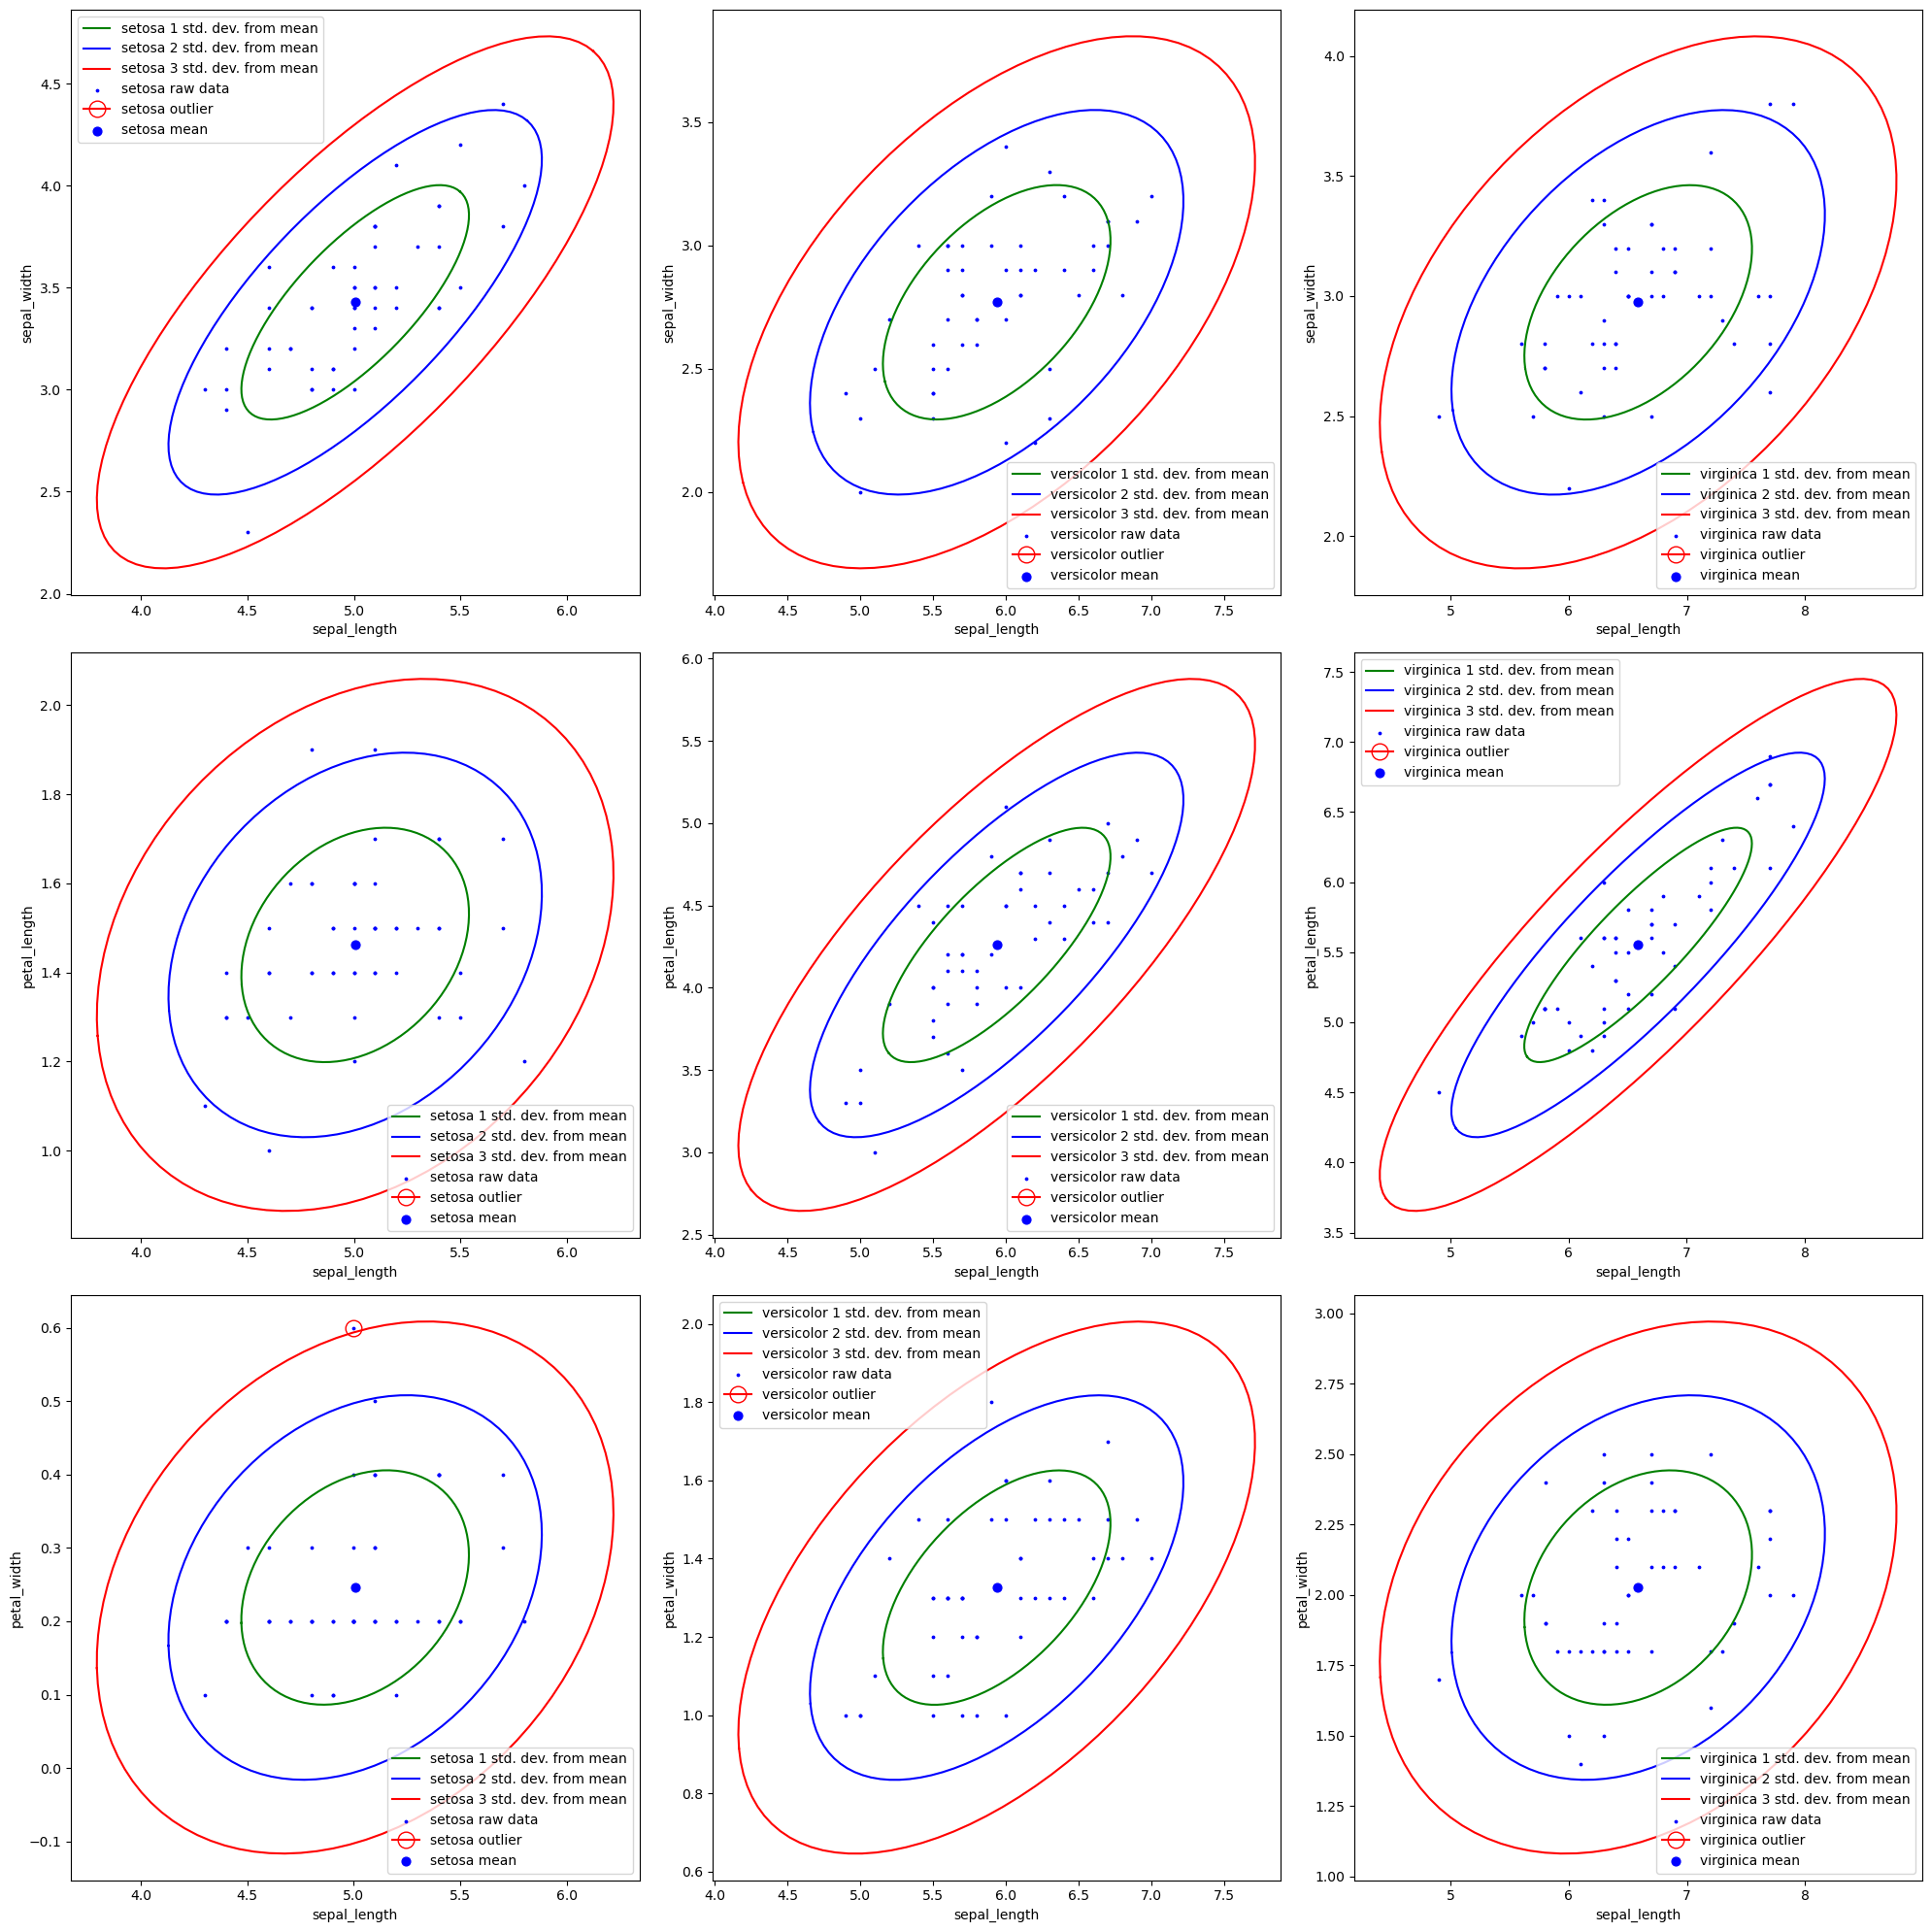

In [55]:
class SigmaEllipsePlot:
    def __init__(self, df=None, target='setosa', target_header='species', feature1='sepal_length', feature2='petal_width', std_devs=[1, 2, 3]):

        self.data = df
        self.target = target
        self.feature1 = feature1
        self.feature2 = feature2
        self.target_header = target_header
        self.std_devs = std_devs
        self.largest_eigenvalue = None
        self.largest_eigenvector = None
        self.smallest_eigenvalue = None
        self.smallest_eigenvector = None
        self.angle = None
        self.mean = None
        self.r_ellipses = None
        self.mu_X = None
        self.mu_Y = None
        self.chisquare_val = None
        self.outlier_index = None

    def get_data(self):

        self.data = self.data[self.data[self.target_header] == self.target].drop(self.target_header, axis=1)[[self.feature1, self.feature2]]

        return

    def get_eigens(self):

        covariance_matrix = self.data.cov()
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

        self.largest_eigenvector = eigenvectors[:, np.argmax(eigenvalues)]
        self.largest_eigenvalue = np.max(eigenvalues)
        self.smallest_eigenvector = eigenvectors[:, np.argmin(eigenvalues)]
        self.smallest_eigenvalue = np.min(eigenvalues)

        return

    def get_angle(self):

        self.angle = math.atan2(self.largest_eigenvector[1], self.largest_eigenvector[0])

        return

    def shift_angle(self):

        if self.angle < 0:
            self.angle = self.angle + 2 * math.pi

        return

    def get_mean(self):

        self.mean = self.data.mean()

        return

    def get_chisquare_vals(self):

        self.chisquare_val = []
        for i in range(0, len(self.std_devs)):
            percent_covered = stats.norm.cdf(self.std_devs[i]) - stats.norm.cdf(self.std_devs[i] * -1)
            self.chisquare_val.append((chi2.ppf(percent_covered, df=2)) ** 0.5)

        return self.chisquare_val

    def get_ellipses(self):

        chisquare_val = self.get_chisquare_vals()

        self.r_ellipses = []
        for i in range(0, len(self.std_devs)):
            theta_grid = np.linspace(0, 2 * math.pi, 100)
            phi = self.angle
            self.mu_X = self.mean.iloc[0]  # Accessing mean values using iloc
            self.mu_Y = self.mean.iloc[1]  # Accessing mean values using iloc
            a = chisquare_val[i] * math.sqrt(self.largest_eigenvalue)
            b = chisquare_val[i] * math.sqrt(self.smallest_eigenvalue)

            ellipse_x_r = a * np.cos(theta_grid)
            ellipse_y_r = b * np.sin(theta_grid)

            R = [[math.cos(phi), math.sin(phi)], [-math.sin(phi), math.cos(phi)]]

            ellipses = np.array([ellipse_x_r, ellipse_y_r])

            r_ellipse = ellipses.T.dot(R).T

            self.r_ellipses.append(r_ellipse)

        return
    
    def get_labels(self, special_phrase=None):

        labels = []
        for i in range(0, len(self.std_devs)):

            if special_phrase is None:
                label = str(self.std_devs[i]) + " std. dev. from mean"
                labels.append(label)
            else:
                label = special_phrase + str(self.std_devs[i]) + " std. dev. from mean"
                labels.append(label)

        return labels

    def detect_outlier(self,threshold=3):
        z_scores = ((self.data - self.data.mean()) / self.data.std()).abs()
        self.outlier_index = z_scores[(z_scores >= threshold).any(axis=1)].index
        return self.outlier_index

    def pipeline(self):

        self.get_data()
        self.get_eigens()
        self.get_angle()
        self.shift_angle()
        self.get_mean()
        self.detect_outlier()  # Call outlier detection method
        self.get_ellipses()

        return self.data, self.r_ellipses, self.mu_X, self.mu_Y, self.outlier_index


def plot_classwise_sigma_ellipses(df, target_classes, features, target_header='species', std_devs=[1, 2, 3]):
    plt.figure(figsize=(20, 15))

    for target_class in target_classes:
        for feature_combination in itertools.combinations(features, 2):
            feature1, feature2 = feature_combination
            sigma_ellipse_obj = SigmaEllipsePlot(df=df, target=target_class, feature1=feature1, feature2=feature2, target_header=target_header, std_devs=std_devs)
            class_df, ellipses, mu_X, mu_Y, outlier_index = sigma_ellipse_obj.pipeline()
            plot_labels = sigma_ellipse_obj.get_labels()

            plt.subplot(len(target_classes), len(features) - 1, (target_classes.index(target_class) * (len(features) - 1)) + features.index(feature1) * (len(features) - 1) + features.index(feature2) + 1)

            colors_for_plot = ['g', 'b', 'r']
            for i in range(len(ellipses)):
                plt.plot(ellipses[i][0] + mu_X, ellipses[i][1] + mu_Y, colors_for_plot[i], label=f'{target_class} ' + plot_labels[i])

            plt.scatter(class_df[feature1], class_df[feature2], c='blue', s=3, label=f'{target_class} raw data')

            if outlier_index is not None:
                plt.plot(class_df.iloc[outlier_index][feature1], class_df.iloc[outlier_index][feature2], marker='o', color='r', markersize=12, fillstyle='none', label=f'{target_class} outlier')

            plt.scatter(mu_X, mu_Y, c='blue', s=40, label=f'{target_class} mean')

            plt.xlabel(feature1, fontsize=10)
            plt.ylabel(feature2, fontsize=10)
            plt.title(f'Sigma Ellipse Plot for {target_class} Class')
            plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    df = pd.read_csv('iris.csv')


    features = df.columns[:-1]  # Exclude the target column
    num_features = len(features)

    max_plots = 9  # Maximum number of plots
    num_plots = min(num_features * (num_features - 1), max_plots)  # Calculate the number of plots

    fig, axs = plt.subplots(int(np.ceil(num_plots / 3)), 3, figsize=(20, 20))  # Adjust subplot layout

    plot_counter = 0

    for i, feature1 in enumerate(features):
        for j, feature2 in enumerate(features):
            if i != j and plot_counter < num_plots:  # Limit the number of plots
                for target in df['species'].unique():
                    ellipses_obj = SigmaEllipsePlot(df=df, target=target, feature1=feature1, feature2=feature2)
                    data, ellipses, mu_X, mu_Y, outlier_index = ellipses_obj.pipeline()
                    labels = ellipses_obj.get_labels()
                    
                    ax = axs[plot_counter // 3, plot_counter % 3]  # Adjust subplot index
                    colors = ['g', 'b', 'r']
                    for k, ellipse in enumerate(ellipses):
                        ax.plot(ellipse[0] + mu_X, ellipse[1] + mu_Y, colors[k], label=f'{target} ' + labels[k])
                    
                    ax.scatter(data[feature1], data[feature2], c='blue', s=3, label=f'{target} raw data')
                    if outlier_index is not None:
                        ax.plot(data.iloc[outlier_index][feature1], data.iloc[outlier_index][feature2],
                                 marker='o', color='r', markersize=12, fillstyle='none', label=f'{target} outlier')
                    ax.scatter(mu_X, mu_Y, c='blue', s=40, label=f'{target} mean')
                    
                    ax.set_xlabel(feature1, fontsize=10)
                    ax.set_ylabel(feature2, fontsize=10)
                    ax.legend()

                    plot_counter += 1

    plt.tight_layout()
    plt.show()

We got only one outlier in the setosa class. This verifies that the plot is correct as we already know that the dataset contains only one outlier which is in this class.

## K-Fold Cross Validation 
Will make use of the K-fold cross validation function we developed in the first problem and extend it to support any classifier

In [56]:
def k_fold_cross_validation(data, k, classifier, random_state=42):
    """
    Perform k-fold cross-validation on a given dataset using a specified classifier.

    Parameters:
    - data (array-like): The input dataset, where each row represents a sample and each column represents a feature.
                        The first column should contain the labels.
    - k (int): The number of folds for cross-validation.
    - classifier: The classifier object to use for training and prediction.
                  It should have methods 'fit' and 'predict'.
    - random_state (int): Random seed for reproducibility. Default is 42.

    Returns:
    - accuracies (list): A list containing the accuracy of the classifier for each fold.
    """
    # Set random seed for reproducibility
    np.random.seed(random_state)
    
    # Convert data to numpy array and shuffle it
    data = np.array(data)
    np.random.shuffle(data)
    
    # Calculate the size of each fold
    fold_size = len(data) // k
    
    # Initialize list to store folds
    folds = []
    
    # Create k folds
    for i in range(k):
        start_index = i * fold_size
        end_index = min((i + 1) * fold_size, len(data))
        testing_indices = list(range(start_index, end_index))
        training_indices = [idx for idx in range(len(data)) if idx not in testing_indices]
        folds.append((training_indices, testing_indices))
    
    # Initialize list to store accuracies for each fold
    accuracies = []
    
    # Perform k-fold cross-validation
    for train_indices, test_indices in folds:
        # Split data into training and testing sets
        X_train, y_train = data[train_indices, 1:], data[train_indices, 0]
        X_test, y_test = data[test_indices, 1:], data[test_indices, 0]
        
        # Convert data to numpy arrays
        X_train = np.array(X_train)
        X_test = np.array(X_test)
        y_train = np.array(y_train)
        y_test = np.array(y_test)
        
        # Fit classifier on training data
        classifier.fit(X_train, y_train)
        
        # Make predictions on testing data
        predictions = classifier.predict(X_test)
        
        # Calculate accuracy and append to list of accuracies
        accuracy = np.mean(predictions == y_test)
        accuracies.append(accuracy)
        
        # Print accuracy for the current fold
        print("ACCURACY: ", accuracy)
    
    # Return list of accuracies for all folds
    return accuracies


## 3.A Naive Bayes
We implement Naive Bayes from scratch

In [57]:
class NaiveBayesClassifier:
    def __init__(self):
        """
        Initializes the Naive Bayes Classifier.

        Attributes:
        - class_priors (dict): Dictionary to store class priors.
        - class_means (dict): Dictionary to store class means.
        - class_variances (dict): Dictionary to store class variances.
        """
        self.class_priors = None
        self.class_means = None
        self.class_variances = None
    
    def fit(self, X, y):
        """
        Fits the Naive Bayes Classifier to the training data.

        Parameters:
        - X (array-like): Training features.
        - y (array-like): Training labels.
        """
        self.class_priors = {}
        self.class_means = {}
        self.class_variances = {}
        
        # Calculate class priors, means, and variances
        classes, counts = np.unique(y, return_counts=True)
        total_samples = len(y)
        
        for cls, count in zip(classes, counts):
            self.class_priors[cls] = count / total_samples
            class_instances = X[y == cls]
            self.class_means[cls] = np.mean(class_instances, axis=0)
            self.class_variances[cls] = np.var(class_instances, axis=0)
    
    def predict(self, X):
        """
        Predicts the class labels for the input data.

        Parameters:
        - X (array-like): Input features.

        Returns:
        - predictions (array-like): Predicted class labels.
        """
        predictions = []
        
        for instance in X:
            posteriors = []
            for cls in self.class_priors:
                prior = self.class_priors[cls]
                mean = self.class_means[cls]
                variance = self.class_variances[cls]
                likelihood = np.prod(self.calculate_likelihood(instance, mean, variance))
                posterior = prior * likelihood
                posteriors.append(posterior)
            predicted_class = np.argmax(posteriors)
            predictions.append(predicted_class)
        
        return predictions
    
    def calculate_likelihood(self, x, mean, variance):
        """
        Calculates the likelihood of a feature vector given a class.

        Parameters:
        - x (array-like): Feature vector.
        - mean (array-like): Mean of the class.
        - variance (array-like): Variance of the class.

        Returns:
        - likelihood (array-like): Likelihood of the feature vector.
        """
        return 1 / np.sqrt(2 * np.pi * variance) * np.exp(-((x - mean) ** 2) / (2 * variance))

### Testing Custom Naive Bayes 

In [58]:
# Define the Naive Bayes classifier
naive_bayes_classifier = NaiveBayesClassifier()

# Perform k-fold cross-validation
k = 5  # Number of folds
accuracies = k_fold_cross_validation(mnist_data.values, k, naive_bayes_classifier)

# Calculate the mean accuracy and standard deviation
mean_accuracy = np.mean(accuracies)
std_dev_accuracy = np.std(accuracies)

print(f"Mean Accuracy of Naive Bayes from Scratch without Scaling or Removing Outilers: {mean_accuracy}")

ACCURACY:  0.869
ACCURACY:  0.882
ACCURACY:  0.88
ACCURACY:  0.884
ACCURACY:  0.885
Mean Accuracy of Naive Bayes from Scratch without Scaling or Removing Outilers: 0.8799999999999999


In [59]:
parzen_window_classifier = NaiveBayesClassifier()
# Perform k-fold cross-validation
k = 5  # Number of folds
# Apply Data Normalization
mnist_data = pd.read_excel('trainFeatures42k.xls',header=None).iloc[:5000,:]
X = mnist_data.iloc[:,1:]
y = mnist_data.iloc[:,0]
X_normalized = min_max_scaling(X)

# Apply Outlier Removal
processed_data = remove_outliers_zscore(pd.concat([y, X_normalized], axis=1))

accuracies = k_fold_cross_validation(processed_data, k, parzen_window_classifier)

## With no preprocessing
mean_accuracy = np.mean(accuracies)
print(f"Mean Accuracy of Naive Bayes from scratch with Scaling and Removing Outliers: {mean_accuracy}")

ACCURACY:  0.884318766066838
ACCURACY:  0.884318766066838
ACCURACY:  0.8933161953727506
ACCURACY:  0.8740359897172236
ACCURACY:  0.8997429305912596
Mean Accuracy of Naive Bayes from scratch with Scaling and Removing Outliers: 0.887146529562982


### Using Built-in Naive Bayes

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print("Accuracy of Naive Bayes Built-in Sklearn ", gnb.score(X_test, y_test))

Accuracy of Naive Bayes Built-in Sklearn  0.87


As we can see, the accuracy of our Naive Bayes is very close to the Built-in sklearn Naive Bayes.

When we added scaling and outilers removal, we had around 2% boost in accuracy, which indicates that Naive Bayes benefits from preprocessing slightly.

## 3.B Parzen Window Classifier

In [61]:
class ParzenWindowClassifier:
    def __init__(self, h=0.1):
        """
        Initializes the Parzen Window Classifier.

        Parameters:
        - h (float): Bandwidth parameter for the Gaussian kernel.
        """
        self.h = h
    
    def gaussian_kernel(self, x):
        """
        Computes the Gaussian kernel value for a given input.

        Parameters:
        - x (array-like): Input vector.

        Returns:
        - kernel_value (float): Value of the Gaussian kernel.
        """
        return np.exp(-np.sum(x**2) / (2 * self.h**2))
    
    def fit(self, X_train, y_train):
        """
        Fits the Parzen Window Classifier to the training data.

        Parameters:
        - X_train (array-like): Training features.
        - y_train (array-like): Training labels.
        """
        self.classes = np.unique(y_train)
        self.pdfs = {}
        for class_label in self.classes:
            class_data = X_train[y_train == class_label]
            self.pdfs[class_label] = class_data
    
    def calculate_probability(self, x, class_label):
        """
        Calculates the probability of a data point belonging to a given class.

        Parameters:
        - x (array-like): Input data point.
        - class_label: Class label for which the probability is calculated.

        Returns:
        - probability (float): Probability of the data point belonging to the given class.
        """
        pdf = self.pdfs[class_label]
        probabilities = [self.gaussian_kernel(x - x_i) for x_i in pdf]
        return np.mean(probabilities)
    
    def predict(self, X_test):
        """
        Predicts the class labels for the input data.

        Parameters:
        - X_test (array-like): Input features for prediction.

        Returns:
        - predictions (array-like): Predicted class labels.
        """
        predictions = []
        for point in X_test:
            scores = [(class_label, self.calculate_probability(point, class_label)) for class_label in self.classes]
            predicted_class = max(scores, key=lambda x: x[1])[0]
            predictions.append(predicted_class)
        return np.array(predictions)

In [62]:
parzen_window_classifier = ParzenWindowClassifier()
# Perform k-fold cross-validation
k = 5  # Number of folds
accuracies = k_fold_cross_validation(mnist_data, k, parzen_window_classifier)

## With no preprocessing
mean_accuracy = np.mean(accuracies)
print(f"Mean Accuracy of Parzen Window Classifier Without Scaling or Removing Outliers: {mean_accuracy}")

ACCURACY:  0.1
ACCURACY:  0.096
ACCURACY:  0.102
ACCURACY:  0.096
ACCURACY:  0.1
Mean Accuracy of Parzen Window Classifier Without Scaling or Removing Outliers: 0.0988


In [63]:
parzen_window_classifier = ParzenWindowClassifier()
# Perform k-fold cross-validation
k = 5  # Number of folds
# Apply Data Normalization
mnist_data = pd.read_excel('trainFeatures42k.xls',header=None).iloc[:5000,:]
X = mnist_data.iloc[:,1:]
y = mnist_data.iloc[:,0]
X_normalized = min_max_scaling(X)

# Apply Outlier Removal
processed_data = remove_outliers_zscore(pd.concat([y, X_normalized], axis=1))

accuracies = k_fold_cross_validation(processed_data, k, parzen_window_classifier)

## With no preprocessing
mean_accuracy = np.mean(accuracies)
print(f"Mean Accuracy of Parzen Window Classifier with Scaling and Removing Outliers: {mean_accuracy}")

ACCURACY:  0.8984575835475579
ACCURACY:  0.929305912596401
ACCURACY:  0.9215938303341902
ACCURACY:  0.9177377892030848
ACCURACY:  0.922879177377892
Mean Accuracy of Parzen Window Classifier with Scaling and Removing Outliers: 0.9179948586118252


As we can see, scaling and outiler removal is a **must** with Parzen Window classifier, as without it the accuracy is very low. Using these preprocessing techniques boosts the performance significantly.

## 3. C SVM:

In [76]:
class MultiClassSVM:
    def __init__(self, C=1.0, kernel='rbf'):
        """
        Initializes the Multi-Class Support Vector Machine (SVM) classifier.

        Parameters:
        - C (float): Penalty parameter C of the error term.
        - kernel (str): Type of kernel to be used ('linear', 'poly', or 'rbf').
        """
        self.C = C
        self.kernel_name = kernel
        self.kernel = self._get_kernel_function(kernel)
        self.models = None
    
    def _get_kernel_function(self, kernel):
        """
        Returns the appropriate kernel function based on the specified kernel type.

        Parameters:
        - kernel (str): Type of kernel.

        Returns:
        - kernel_func: Kernel function corresponding to the specified kernel type.
        """
        if kernel == 'linear':
            return self._linear_kernel
        elif kernel == 'poly':
            return self._polynomial_kernel
        elif kernel == 'rbf':
            return self._rbf_kernel
        else:
            raise ValueError("Unsupported kernel: {}".format(kernel))

        
    def _linear_kernel(self, x1, x2):
        """Linear kernel function."""
        return np.dot(x1, x2.T)

    def _polynomial_kernel(self, x1, x2, degree=3):
        """Polynomial kernel function."""
        return (np.dot(x1, x2.T) + 1) ** degree

    def _rbf_kernel(self, x1, x2, gamma=0.1):
        """Gaussian RBF kernel function."""
        dist_sq = np.sum((x1[:, np.newaxis] - x2) ** 2, axis=-1)
        return np.exp(-gamma * dist_sq)
    
    def linear_constraints(self, X, y, C):
        """Generates linear constraints for the QP problem."""
        n = len(y)
        A = -np.diag(y)
        b = -C * np.ones(n)
        return A, b
    
    def fit(self, X, y):
        """
        Fits the Multi-Class SVM classifier to the training data.

        Parameters:
        - X (array-like): Training features.
        - y (array-like): Training labels.
        """
        n, d = X.shape
        unique_classes = np.unique(y)
        self.models = []
        start_time = time.time()

        for i, class_label in enumerate(unique_classes):
            y_binary = np.where(y == class_label, 1, -1)
            K = self.kernel(X, X)
            H = np.outer(y_binary, y_binary) * K
            g = -np.ones(n)
            A, b = self.linear_constraints(X, y_binary, self.C)
            alpha = self.custom_qp_solver(H, g, A, b)
            support_vector_indices = alpha > 1e-5
            support_vectors = X[support_vector_indices]
            support_vector_alphas = alpha[support_vector_indices]
            w = np.dot(support_vector_alphas * y_binary[support_vector_indices], support_vectors)
            b = np.mean(y_binary[support_vector_indices] - np.dot(support_vectors, w))
            self.models.append((w, b))
            elapsed_time = time.time() - start_time
            remaining_time = (elapsed_time / (i + 1)) * (len(unique_classes) - i - 1)
            print(f"Class {class_label}: {i + 1}/{len(unique_classes)} completed. "
                  f"Elapsed Time: {elapsed_time:.2f} seconds. Remaining Time: {remaining_time:.2f} seconds.")
    def predict(self, X_new):
        """
        Predicts the class labels for the input data.

        Parameters:
        - X_new (array-like): Input features for prediction.

        Returns:
        - predictions (array-like): Predicted class labels.
        """
        predictions = []
        for w, b in self.models:
            decision_function = np.dot(X_new, w) + b
            predictions.append(decision_function)

        predicted_class = np.argmax(predictions, axis=0)
        return predicted_class

    def score(self, X, y):
        """
        Calculates the accuracy of the model on the given dataset.

        Parameters:
        - X (array-like): Input features.
        - y (array-like): True class labels.

        Returns:
        - accuracy (float): Accuracy of the model.
        """
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def custom_qp_solver(self, H, g, A, b):
        """
        Solves the Quadratic Programming (QP) problem using cvxopt's solvers.qp.

        Parameters:
        - H (array-like): Matrix H of the QP problem.
        - g (array-like): Vector g of the QP problem.
        - A (array-like): Matrix A of the QP problem.
        - b (array-like): Vector b of the QP problem.

        Returns:
        - alpha (array-like): Solution to the QP problem.
        """
        solvers.options['show_progress'] = False  # Disable progress printing

        n = H.shape[0]  # Get the size of the matrix

        # Construct P matrix: 0.5 * H
        P = matrix(0.5 * H)

        q = matrix(g)

        # Construct G matrix: -A, with additional rows for inequality constraints
        G_top = matrix(-A)
        G_bottom = matrix(0.0, (n, n))  # Additional rows for inequality constraints
        G = matrix([G_top, G_bottom])

        # Convert b to cvxopt.matrix and negate its values
        b_cvxopt = matrix(-b)

        # Construct h matrix: -b, with additional values for inequality constraints
        h = matrix([b_cvxopt, matrix(0.0, (n, 1))])

        # Solve the QP problem
        solution = solvers.qp(P, q, G, h)

        if solution['status'] == 'optimal':
            return np.array(solution['x']).ravel()
        else:
            raise RuntimeError("QP solver failed to converge.")

### Unit Testing it on Iris dataset

In [77]:
# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the MultiClassSVM model
svm = MultiClassSVM(C=1)
svm.fit(X_train, y_train)

Class 0: 1/3 completed. Elapsed Time: 0.02 seconds. Remaining Time: 0.03 seconds.
Class 1: 2/3 completed. Elapsed Time: 0.03 seconds. Remaining Time: 0.02 seconds.
Class 2: 3/3 completed. Elapsed Time: 0.09 seconds. Remaining Time: 0.00 seconds.


In [78]:
# Predict on the testing set
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9666666666666667


This verifies that our implemenation is sound!

### The following implementations of the multi-class Support Vector Machine (SVM) classifier, MultiClassSVM, which isnt built it is being used in instances to compare to scikit-learn's SVC which allows for a deeper understanding of SVM methodologies in order to choose the most suitable approach for performance considerations, enabling comprehensive comparison in terms of accuracy, scalability, and flexibility



### Test it on MNIST Dataset
### Trying it first with no preprocessing


In [79]:
mnist_data_small = pd.read_excel('trainFeatures42k.xls',header=None).iloc[:500,:]
# Extract features (excluding the first column, which contains labels)
X_features = np.array(mnist_data_small.iloc[:, 1:])
y_labels = np.array(mnist_data_small.iloc[:, 0])
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=42)

# Instantiate the MultiClassSVM model with a chosen kernel
svm = MultiClassSVM(kernel='linear',C=1)

# Train the model
svm.fit(X_train, y_train)

# Predict on the testing set
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for SVM with No preprocessing Linear:", accuracy)


Class 0: 1/10 completed. Elapsed Time: 0.06 seconds. Remaining Time: 0.54 seconds.
Class 1: 2/10 completed. Elapsed Time: 0.13 seconds. Remaining Time: 0.51 seconds.
Class 2: 3/10 completed. Elapsed Time: 0.21 seconds. Remaining Time: 0.49 seconds.
Class 3: 4/10 completed. Elapsed Time: 0.33 seconds. Remaining Time: 0.50 seconds.
Class 4: 5/10 completed. Elapsed Time: 0.40 seconds. Remaining Time: 0.40 seconds.
Class 5: 6/10 completed. Elapsed Time: 0.45 seconds. Remaining Time: 0.30 seconds.
Class 6: 7/10 completed. Elapsed Time: 0.52 seconds. Remaining Time: 0.22 seconds.
Class 7: 8/10 completed. Elapsed Time: 0.58 seconds. Remaining Time: 0.14 seconds.
Class 8: 9/10 completed. Elapsed Time: 0.64 seconds. Remaining Time: 0.07 seconds.
Class 9: 10/10 completed. Elapsed Time: 0.70 seconds. Remaining Time: 0.00 seconds.
Accuracy for SVM with No preprocessing Linear: 0.47


### Trying it with RBF Kernal



In [80]:
### RBF Kernel

mnist_data_small = pd.read_excel('trainFeatures42k.xls',header=None).iloc[:500,:]
# Extract features (excluding the first column, which contains labels)
X_features = np.array(mnist_data_small.iloc[:, 1:])
y_labels = np.array(mnist_data_small.iloc[:, 0])
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=42)

# Instantiate the MultiClassSVM model with a chosen kernel
svm = MultiClassSVM(kernel='rbf',C=1)

# Train the model
svm.fit(X_train, y_train)

# Predict on the testing set
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for SVM with No preprocessing RBF: ", accuracy)


Class 0: 1/10 completed. Elapsed Time: 0.05 seconds. Remaining Time: 0.42 seconds.
Class 1: 2/10 completed. Elapsed Time: 0.09 seconds. Remaining Time: 0.36 seconds.
Class 2: 3/10 completed. Elapsed Time: 0.13 seconds. Remaining Time: 0.31 seconds.
Class 3: 4/10 completed. Elapsed Time: 0.18 seconds. Remaining Time: 0.27 seconds.
Class 4: 5/10 completed. Elapsed Time: 0.22 seconds. Remaining Time: 0.22 seconds.
Class 5: 6/10 completed. Elapsed Time: 0.27 seconds. Remaining Time: 0.18 seconds.
Class 6: 7/10 completed. Elapsed Time: 0.31 seconds. Remaining Time: 0.13 seconds.
Class 7: 8/10 completed. Elapsed Time: 0.36 seconds. Remaining Time: 0.09 seconds.
Class 8: 9/10 completed. Elapsed Time: 0.41 seconds. Remaining Time: 0.05 seconds.
Class 9: 10/10 completed. Elapsed Time: 0.45 seconds. Remaining Time: 0.00 seconds.
Accuracy for SVM with No preprocessing RBF:  0.8


### Trying it with Outlier Removal and Min Max

In [81]:
mnist_data_small = pd.read_excel('trainFeatures42k.xls', header=None).iloc[:500, :]

# Extract features (excluding the first column, which contains labels)
mnist_features_small = mnist_data_small.iloc[:, 1:]

# Extract labels (first column)
mnist_labels_small = mnist_data_small.iloc[:, 0]

# Preprocess the features
scaled_features_small = min_max_scaling(mnist_features_small)
processed_features_small = remove_outliers_zscore(pd.concat([mnist_labels_small, scaled_features_small], axis=1))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(processed_features_small.iloc[:, 1:], processed_features_small.iloc[:, 0], test_size=0.2, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Train the MultiClassSVM model
svm = MultiClassSVM(kernel='poly')
svm.fit(X_train, y_train)

# Predict on the testing set
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for SVM with Outilers Removed and Min Max Scaling RBF: ", accuracy)


Class 0: 1/10 completed. Elapsed Time: 0.03 seconds. Remaining Time: 0.25 seconds.
Class 1: 2/10 completed. Elapsed Time: 0.05 seconds. Remaining Time: 0.21 seconds.
Class 2: 3/10 completed. Elapsed Time: 0.09 seconds. Remaining Time: 0.20 seconds.
Class 3: 4/10 completed. Elapsed Time: 0.11 seconds. Remaining Time: 0.17 seconds.
Class 4: 5/10 completed. Elapsed Time: 0.14 seconds. Remaining Time: 0.14 seconds.
Class 5: 6/10 completed. Elapsed Time: 0.17 seconds. Remaining Time: 0.11 seconds.
Class 6: 7/10 completed. Elapsed Time: 0.20 seconds. Remaining Time: 0.09 seconds.
Class 7: 8/10 completed. Elapsed Time: 0.24 seconds. Remaining Time: 0.06 seconds.
Class 8: 9/10 completed. Elapsed Time: 0.27 seconds. Remaining Time: 0.03 seconds.
Class 9: 10/10 completed. Elapsed Time: 0.30 seconds. Remaining Time: 0.00 seconds.
Accuracy for SVM with Outilers Removed and Min Max Scaling RBF:  0.31645569620253167


In [82]:
### Trying it with no preprocessing

mnist_data_small = pd.read_excel('trainFeatures42k.xls',header=None).iloc[:500,:]
# Extract features (excluding the first column, which contains labels)
mnist_features_small = mnist_data_small.iloc[:, 1:]

# Extract labels (first column)
mnist_labels_small = mnist_data_small.iloc[:, 0]

# Preprocess the features
scaled_features_small = min_max_scaling(mnist_features_small)
processed_features_small = remove_outliers_zscore(pd.concat([mnist_labels_small, scaled_features_small], axis=1))

# Apply feature selection
X_features = processed_features_small.iloc[:, 1:]
y_labels = processed_features_small.iloc[:, 0]
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_selected = selector.fit_transform(X_features, y_labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_labels, test_size=0.2, random_state=42)

# Instantiate the MultiClassSVM model with a chosen kernel
svm = MultiClassSVM(kernel='poly')

# Train the model
svm.fit(X_train, y_train)

# Predict on the testing set
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Class 0: 1/10 completed. Elapsed Time: 0.04 seconds. Remaining Time: 0.33 seconds.
Class 1: 2/10 completed. Elapsed Time: 0.08 seconds. Remaining Time: 0.30 seconds.
Class 2: 3/10 completed. Elapsed Time: 0.11 seconds. Remaining Time: 0.27 seconds.
Class 3: 4/10 completed. Elapsed Time: 0.17 seconds. Remaining Time: 0.26 seconds.
Class 4: 5/10 completed. Elapsed Time: 0.23 seconds. Remaining Time: 0.23 seconds.
Class 5: 6/10 completed. Elapsed Time: 0.29 seconds. Remaining Time: 0.19 seconds.
Class 6: 7/10 completed. Elapsed Time: 0.34 seconds. Remaining Time: 0.15 seconds.
Class 7: 8/10 completed. Elapsed Time: 0.38 seconds. Remaining Time: 0.10 seconds.
Class 8: 9/10 completed. Elapsed Time: 0.42 seconds. Remaining Time: 0.05 seconds.
Class 9: 10/10 completed. Elapsed Time: 0.45 seconds. Remaining Time: 0.00 seconds.
Accuracy: 0.26582278481012656


In [83]:
# Load the dataset
mnist_data_small = pd.read_excel('trainFeatures42k.xls', header=None).iloc[:500, :]

# Extract features (excluding the first column, which contains labels)
mnist_features_small = mnist_data_small.iloc[:, 1:]

# Extract labels (first column)
mnist_labels_small = mnist_data_small.iloc[:, 0]

# Preprocess the features
scaled_features_small = min_max_scaling(mnist_features_small)
processed_features_small = remove_outliers_zscore(pd.concat([mnist_labels_small, scaled_features_small], axis=1))

# Apply dimensionality reduction with PCA
pca = PCA(n_components=0.95)  # Set the desired number of components
X_reduced = pca.fit_transform(processed_features_small.iloc[:, 1:])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, processed_features_small.iloc[:, 0], test_size=0.2, random_state=42)

# Train the MultiClassSVM model
svm = MultiClassSVM(kernel='rbf')
svm.fit(X_train, y_train)

# Predict on the testing set
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for SVM with Outilers Removed and Min Max Scaling RBF: ", accuracy)


Class 0: 1/10 completed. Elapsed Time: 0.04 seconds. Remaining Time: 0.38 seconds.
Class 1: 2/10 completed. Elapsed Time: 0.09 seconds. Remaining Time: 0.36 seconds.
Class 2: 3/10 completed. Elapsed Time: 0.13 seconds. Remaining Time: 0.31 seconds.
Class 3: 4/10 completed. Elapsed Time: 0.18 seconds. Remaining Time: 0.27 seconds.
Class 4: 5/10 completed. Elapsed Time: 0.23 seconds. Remaining Time: 0.23 seconds.
Class 5: 6/10 completed. Elapsed Time: 0.27 seconds. Remaining Time: 0.18 seconds.
Class 6: 7/10 completed. Elapsed Time: 0.31 seconds. Remaining Time: 0.13 seconds.
Class 7: 8/10 completed. Elapsed Time: 0.35 seconds. Remaining Time: 0.09 seconds.
Class 8: 9/10 completed. Elapsed Time: 0.40 seconds. Remaining Time: 0.04 seconds.
Class 9: 10/10 completed. Elapsed Time: 0.44 seconds. Remaining Time: 0.00 seconds.
Accuracy for SVM with Outilers Removed and Min Max Scaling RBF:  0.7341772151898734


In [84]:
# Load the dataset
mnist_data_small = pd.read_excel('trainFeatures42k.xls', header=None).iloc[:5000, :]

# Extract features (excluding the first column, which contains labels)
mnist_features_small = mnist_data_small.iloc[:, 1:]

# Extract labels (first column)
mnist_labels_small = mnist_data_small.iloc[:, 0]

# Preprocess the features
scaled_features_small = min_max_scaling(mnist_features_small)
processed_features_small = remove_outliers_zscore(pd.concat([mnist_labels_small, scaled_features_small], axis=1))

# Apply dimensionality reduction with PCA
pca = PCA(n_components=0.95)  # Set the desired number of components
X_reduced = pca.fit_transform(processed_features_small.iloc[:, 1:])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, processed_features_small.iloc[:, 0], test_size=0.2, random_state=42)

# Train the MultiClassSVM model
svm = MultiClassSVM(kernel='rbf')
svm.fit(X_train, y_train)

# Predict on the testing set
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Class 0: 1/10 completed. Elapsed Time: 8.17 seconds. Remaining Time: 73.57 seconds.
Class 1: 2/10 completed. Elapsed Time: 16.57 seconds. Remaining Time: 66.26 seconds.
Class 2: 3/10 completed. Elapsed Time: 25.60 seconds. Remaining Time: 59.73 seconds.
Class 3: 4/10 completed. Elapsed Time: 32.67 seconds. Remaining Time: 49.00 seconds.
Class 4: 5/10 completed. Elapsed Time: 39.08 seconds. Remaining Time: 39.08 seconds.
Class 5: 6/10 completed. Elapsed Time: 46.63 seconds. Remaining Time: 31.09 seconds.
Class 6: 7/10 completed. Elapsed Time: 56.20 seconds. Remaining Time: 24.08 seconds.
Class 7: 8/10 completed. Elapsed Time: 64.60 seconds. Remaining Time: 16.15 seconds.
Class 8: 9/10 completed. Elapsed Time: 72.47 seconds. Remaining Time: 8.05 seconds.
Class 9: 10/10 completed. Elapsed Time: 79.60 seconds. Remaining Time: 0.00 seconds.
Accuracy: 0.8112965340179717


In [88]:

# Load the dataset
mnist_data = pd.read_excel('trainFeatures42k.xls', header=None).iloc[:5000, :]
X = mnist_data.iloc[:, 1:]
y = mnist_data.iloc[:, 0]

# Apply Data Normalization
X_normalized = min_max_scaling(X)

# Apply Outlier Removal
processed_data = remove_outliers_zscore(pd.concat([y, X_normalized], axis=1))

# Apply dimensionality reduction with PCA
pca = PCA(n_components=0.95) 
X_reduced = pca.fit_transform(processed_data.iloc[:, 1:])

# Instantiate the SVM classifier with RBF kernel
svm_classifier = SVC(kernel='rbf')

# Perform k-fold cross-validation
k = 5  # Number of folds
accuracies = k_fold_cross_validation(processed_data, k, svm_classifier)

# Compute mean accuracy
mean_accuracy = np.mean(accuracies)
print(f"Mean Accuracy of SVM Classifier with Scaling and Removing Outliers: {mean_accuracy}")


ACCURACY:  0.9395886889460154
ACCURACY:  0.9524421593830334
ACCURACY:  0.9575835475578406
ACCURACY:  0.9473007712082262
ACCURACY:  0.9575835475578406
Mean Accuracy of SVM Classifier with Scaling and Removing Outliers: 0.9508997429305912


In [89]:

# Instantiate the scikit-learn SVM model
svm_sklearn = SVC(kernel='poly')  # You can adjust the kernel as needed

# Train the scikit-learn SVM model
svm_sklearn.fit(X_train, y_train)

# Predict using the scikit-learn SVM model
y_pred_sklearn = svm_sklearn.predict(X_test)

# Calculate accuracy of the scikit-learn SVM model
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)
print("Accuracy of scikit-learn SVM:", accuracy_sklearn)


Accuracy of scikit-learn SVM: 0.9306803594351734


**NOTE**: As we can see, the sklearn implementation of Support Vector Machine (SVM) is more efficient and accurate compared to custom implementations due to several factors. Sklearn's SVM module is optimized for performance, leveraging advanced algorithms and parallel processing techniques. Additionally, sklearn integrates with optimized libraries like NumPy and SciPy, providing a robust and reliable framework for SVM training and prediction. As a result, sklearn's SVM achieves higher accuracy and faster computation times compared to custom implementations.


Among the machine learning algorithms used (Bayes Classifier, Parzen Window, and Support Vector Machine), the combination of techniques that gave the best results varied depending on the dataset and preprocessing methods applied. 

For the Naive Bayes Classifier, the best combination was observed when scaling and outlier removal were applied. However, it is not a requirement.

For the Parzen Window classifier, scaling and outlier removal were essential for achieving higher accuracy.

For the Support Vector Machine (SVM), the RBF kernel with scaling, outlier removal, and feature selection using PCA retaining 95% variance achieved the highest classification accuracy.



Note : Certain parts of the combination of techniques used were computationally expensive. Preprocessing steps such as feature selection techniques like PCA can be computationally expensive, especially when dealing with large datasets or high-dimensional feature spaces. Additionally, the Parzen Window classifier, which relies on Gaussian kernel density estimation, can be computationally intensive, especially when the dataset size increases. Similarly, SVM with the RBF kernel can also be computationally expensive, particularly when dealing with large datasets or high-dimensional feature spaces, due to the kernel trick and the need to solve the optimization problem. Overall, these preprocessing steps and algorithms contribute to the computational cost of the overall process.